# Search and Destroy Analysis

The data includes each round's attacking and defending teams, the times of the first and second kills ("first blood" and "second kill"), which teams secured those kills, and the final winner.

We investigate several questions:

1. **Does getting the first kill (first blood) increase the chance of winning the round?**  We look at win rates overall and for each team when they secure the first blood versus when they don’t.
2. **Is the timing of the first blood important?**  We check whether faster first bloods translate into higher win rates and identify time windows where the advantage is strongest.
3. **What happens when the first blood is immediately countered?**  We measure how trades (when the opposing team secures the second kill) affect the first blood team’s chance of winning and whether the speed of the trade matters.
4. **How well do teams convert a first blood into a second kill?**  We calculate each team’s conversion rate (getting both the first and second kills) and the associated win rates.
5. **When do teams generally get first blood?**  We compute median first blood times by team.

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style
sns.set(style="whitegrid")

# Load the dataset (Excel file)
file_path = 'CDM.xlsx'
df = pd.read_excel(file_path)

# Display basic information
df.head()

,Date,Attack,Defense,Map,First Blood Time,First Blood Team,Second Kill,Second Kill Team,Winner,Fast Plant? (within 45s),OT
0,2025-08-01,Wolves,SPG,Kurohana,15,SPG,28,SPG,SPG,No,No
1,2025-08-01,Wolves,SPG,Kurohana,21,SPG,30,SPG,Wolves,No,No
2,2025-08-01,Wolves,SPG,Kurohana,23,SPG,25,Wolves,SPG,No,No
3,2025-08-01,Wolves,SPG,Kurohana,18,SPG,30,SPG,SPG,No,No
4,2025-08-01,Wolves,SPG,Kurohana,13,SPG,22,SPG,SPG,No,No


In [38]:
# Load Logo table
logo_df = pd.read_csv('logos.csv')
logo_df

,Team,LogoURL
0,Wolves,![Wolves Logo](https://liquipedia.net/commons...
1,OUG,![OUG Logo](https://liquipedia.net/commons/im...
2,Q9,![Q9 Logo](https://liquipedia.net/commons/ima...
3,Xrock,![XROCK Logo](https://liquipedia.net/commons/...
4,AG,![AG Logo](https://liquipedia.net/commons/ima...
5,SPG,![SPG Logo](https://liquipedia.net/commons/im...
6,GodL,![GodL Logo](https://liquipedia.net/commons/i...
7,Soul,![Soul Logo](https://liquipedia.net/commons/i...
8,DVS,![DVS Logo](https://liquipedia.net/commons/im...
9,Xceed,![Xceed Logo](https://liquipedia.net/commons/...


In [39]:
# Turn off pandas warnings
pd.options.mode.chained_assignment = None

## 1. Impact of First Blood on Win Rate

We first check whether getting the first kill translates into a higher chance of winning the round.  To do this we compare the final winner with the team that got the first blood.  If the two match, the first blood team won that round.

We look at the overall win rate and then break it down by team.

In [40]:
# Indicator: 1 if the team that got the first blood won the round, else 0
df['FirstBloodWin'] = (df['First Blood Team'] == df['Winner']).astype(int)

# Overall win rate when securing first blood
overall_fb_win_rate = df['FirstBloodWin'].mean()
print(f'Overall win rate when getting first blood: {overall_fb_win_rate:.2%}')

# Per-team win rates when they secure first blood vs when they do not
teams = sorted(df['First Blood Team'].unique())
team_summary = []
for team in teams:
    fb_mask = df['First Blood Team'] == team
    total_fb = fb_mask.sum()
    wins_with_fb = (df.loc[fb_mask, 'Winner'] == team).sum()
    win_rate_with_fb = wins_with_fb / total_fb if total_fb > 0 else float('nan')
    
    # Rounds where the team participated (attack or defense) but did not get first blood
    participation_mask = (df['Attack'] == team) | (df['Defense'] == team)
    no_fb_mask = participation_mask & ~fb_mask
    total_no_fb = no_fb_mask.sum()
    wins_without_fb = (df.loc[no_fb_mask, 'Winner'] == team).sum()
    win_rate_without_fb = wins_without_fb / total_no_fb if total_no_fb > 0 else float('nan')
    
    team_summary.append({
        'Team': team,
        'FirstBloodRounds': total_fb,
        'WinRateWithFB': win_rate_with_fb*100,
        'RoundsWithoutFB': total_no_fb,
        'WinRateWithoutFB': win_rate_without_fb*100
    })

import pandas as pd
team_fb_df = pd.DataFrame(team_summary)

# Merge with logo data for visualization
team_fb_df = team_fb_df.merge(logo_df, right_on='Team', how='left', left_on='Team')

team_fb_df.set_index('Team', inplace=True)

team_fb_df

# team_fb_df.to_csv('team_first_blood_summary.csv')

Overall win rate when getting first blood: 68.40%


,FirstBloodRounds,WinRateWithFB,RoundsWithoutFB,WinRateWithoutFB,LogoURL
Team,,,,,
AG,41,78.048780,32,34.375000,![AG Logo](https://liquipedia.net/commons/ima...
DVS,40,65.000000,54,29.629630,![DVS Logo](https://liquipedia.net/commons/im...
GodL,22,68.181818,29,31.034483,![GodL Logo](https://liquipedia.net/commons/i...
OUG,24,54.166667,21,28.571429,![OUG Logo](https://liquipedia.net/commons/im...
Q9,36,77.777778,46,43.478261,![Q9 Logo](https://liquipedia.net/commons/ima...
SPG,38,63.157895,34,47.058824,![SPG Logo](https://liquipedia.net/commons/im...
Soul,48,72.916667,41,24.390244,![Soul Logo](https://liquipedia.net/commons/i...
WL,33,69.696970,29,34.482759,![WL Logo](https://liquipedia.net/commons/ima...
Wolves,34,50.000000,31,32.258065,![Wolves Logo](https://liquipedia.net/commons...


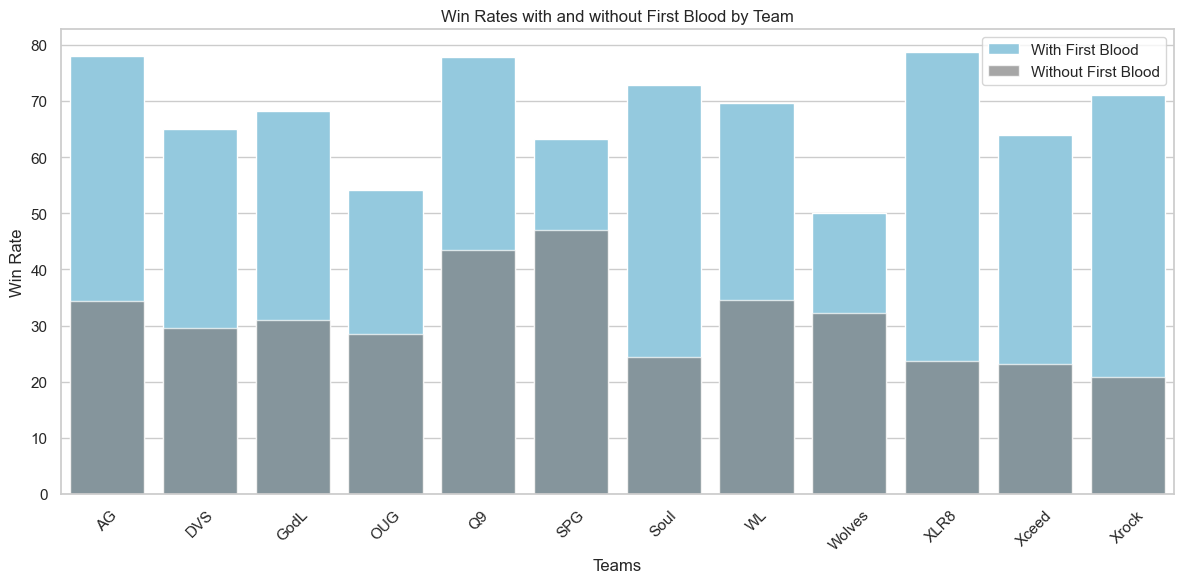

In [41]:
# Plotting the win rates using Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x=team_fb_df.index, y='WinRateWithFB', data=team_fb_df, color='skyblue', label='With First Blood')
sns.barplot(x=team_fb_df.index, y='WinRateWithoutFB', data=team_fb_df, color='grey', label='Without First Blood', alpha=0.7)
plt.title('Win Rates with and without First Blood by Team')
plt.xlabel('Teams')
plt.ylabel('Win Rate')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

## 2. Does the Timing of First Blood Matter?

Next, we explore whether the timing of the first blood influences the round’s outcome.  We calculate the correlation between the first blood time and winning the round, and then group the rounds into time bins to see how win rates differ across early, mid and late kills.

In [42]:
from scipy.stats import pearsonr, spearmanr

# Compute correlation between time of first blood and winning the round
fb_win_indicator = (df['First Blood Team'] == df['Winner']).astype(int)
pearson_corr, pearson_p = pearsonr(df['First Blood Time'], fb_win_indicator)
spearman_corr, spearman_p = spearmanr(df['First Blood Time'], fb_win_indicator)
print(f'Pearson correlation: {pearson_corr:.3f} (p={pearson_p:.3f})')
print(f'Spearman correlation: {spearman_corr:.3f} (p={spearman_p:.3f})')

# Bin the first blood times
bins = [0, 15, 30, 45, 200]
labels = ['0-15s','16-30s','31-45s','>45s']
df['FB_Time_Bin'] = pd.cut(df['First Blood Time'], bins=bins, labels=labels, right=True)

# Compute win rate for each bin
fb_bin_summary = df.groupby('FB_Time_Bin').apply(lambda g: (g['First Blood Team'] == g['Winner']).mean()).reset_index(name='WinRateWithFB')
fb_bin_summary['Rounds'] = df.groupby('FB_Time_Bin')['First Blood Time'].count().values
fb_bin_summary
# fb_bin_summary.to_csv('fb_time_bin_summary.csv', index=False)

Pearson correlation: -0.037 (p=0.459)
Spearman correlation: -0.052 (p=0.292)


,FB_Time_Bin,WinRateWithFB,Rounds
0,0-15s,0.724138,145
1,16-30s,0.699248,133
2,31-45s,0.538462,52
3,>45s,0.680000,75


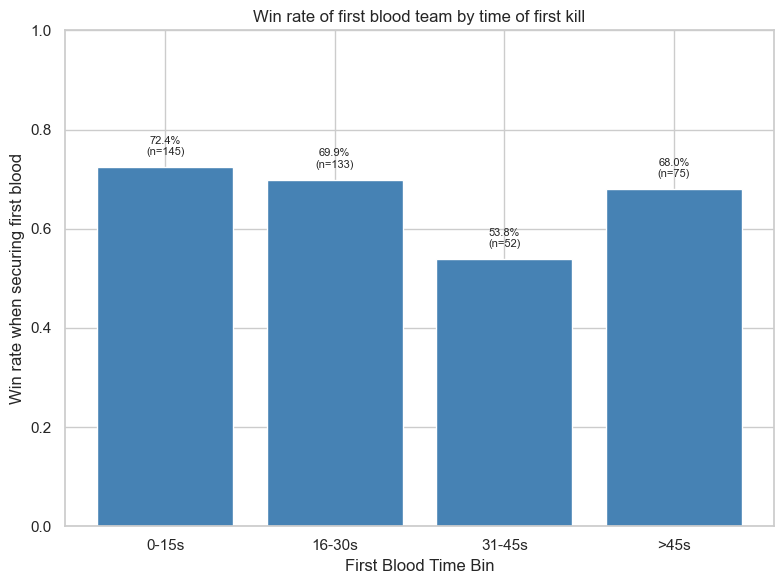

In [43]:
import matplotlib.pyplot as plt

# Bar chart of win rate by first blood time bin
plt.figure(figsize=(8,6))
plt.bar(fb_bin_summary['FB_Time_Bin'], fb_bin_summary['WinRateWithFB'], color='steelblue')
plt.xlabel('First Blood Time Bin')
plt.ylabel('Win rate when securing first blood')
plt.title('Win rate of first blood team by time of first kill')
for i, (rate, rounds) in enumerate(zip(fb_bin_summary['WinRateWithFB'], fb_bin_summary['Rounds'])):
    plt.text(i, rate + 0.02, f'{rate:.1%}\n(n={rounds})', ha='center', va='bottom', fontsize=8)
plt.ylim(0,1)
plt.tight_layout()
plt.show()

## 3. Impact of Trading the First Blood

A **trade** occurs when the team that didn’t get the first blood responds with a kill of their own (i.e. the second kill is by the opposite team).  We calculate how often trades happen, compare win rates when the first blood is traded versus when it isn’t, and examine whether the time to trade affects outcomes.

In [44]:
# Flag trade rounds: second kill by the opposite team
df['IsTrade'] = df['Second Kill Team'] != df['First Blood Team']

# Add 0.1 second to second kill time if equal to first blood time
df['Second Kill'] = df['Second Kill'].where(df['Second Kill'] != df['First Blood Time'], df['Second Kill'] + 0.1)
# Trade time difference
df['TradeTime'] = df['Second Kill'] - df['First Blood Time']

# Win rate when a trade occurs
trade_df = df[df['IsTrade']]
no_trade_df = df[~df['IsTrade']]

win_rate_trade = (trade_df['First Blood Team'] == trade_df['Winner']).mean()
win_rate_no_trade = (no_trade_df['First Blood Team'] == no_trade_df['Winner']).mean()

print(f'Rounds with a trade: {len(trade_df)}')
print(f'Win rate for first blood team when a trade occurs: {win_rate_trade:.2%}')
print(f'Win rate for first blood team when no trade occurs: {win_rate_no_trade:.2%}')

# Correlation between trade time and first blood team winning
from scipy.stats import pearsonr
if len(trade_df) > 1:
    trade_win_indicator = (trade_df['First Blood Team'] == trade_df['Winner']).astype(int)
    trade_corr, trade_p = pearsonr(trade_df['TradeTime'], trade_win_indicator)
    print(f'Correlation between trade time and first blood team winning: {trade_corr:.3f} (p={trade_p:.3f})')

# Group trades by time bins
trade_bins = [0,5,20,200]
trade_labels = ['0-5s','6-20s','>20s']
trade_df['TradeTimeBin'] = pd.cut(trade_df['TradeTime'], bins=trade_bins, labels=trade_labels, right=True)
trade_bin_summary = trade_df.groupby('TradeTimeBin').apply(lambda g: (g['First Blood Team'] == g['Winner']).mean()).reset_index(name='WinRateWithTrade')
trade_bin_summary['TradeRounds'] = trade_df.groupby('TradeTimeBin')['TradeTime'].count().values
trade_bin_summary
# trade_bin_summary.to_csv('trade_time_bin_summary.csv', index=False)

Rounds with a trade: 207
Win rate for first blood team when a trade occurs: 54.59%
Win rate for first blood team when no trade occurs: 82.83%
Correlation between trade time and first blood team winning: 0.022 (p=0.748)


,TradeTimeBin,WinRateWithTrade,TradeRounds
0,0-5s,0.557252,131
1,6-20s,0.487179,39
2,>20s,0.567568,37


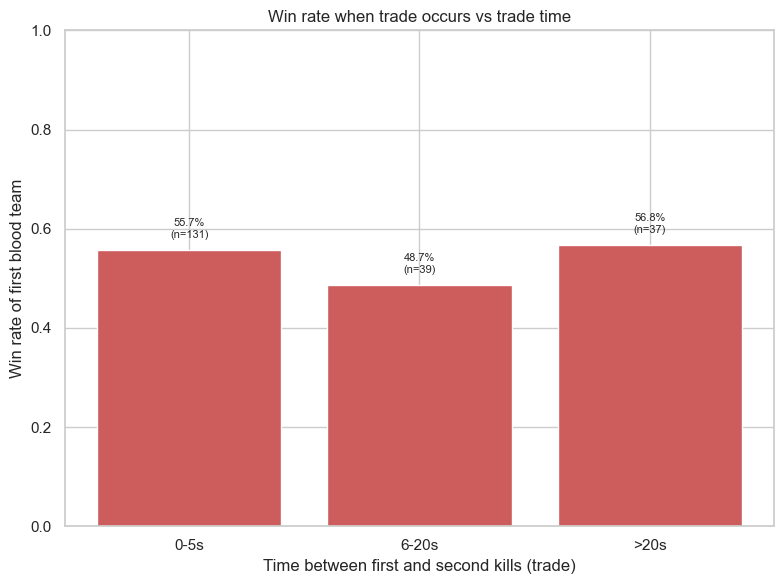

In [45]:
# Plot win rate of first blood team by trade time bin
plt.figure(figsize=(8,6))
plt.bar(trade_bin_summary['TradeTimeBin'], trade_bin_summary['WinRateWithTrade'], color='indianred')
plt.xlabel('Time between first and second kills (trade)')
plt.ylabel('Win rate of first blood team')
plt.title('Win rate when trade occurs vs trade time')
for i, (rate, rounds) in enumerate(zip(trade_bin_summary['WinRateWithTrade'], trade_bin_summary['TradeRounds'])):
    plt.text(i, rate + 0.02, f'{rate:.1%}\n(n={rounds})', ha='center', va='bottom', fontsize=8)
plt.ylim(0,1)
plt.tight_layout()
plt.show()

In [46]:
# Calculate total rounds per team
teams = sorted(set(df['Attack']) | set(df['Defense']))
total_rounds = {team: ((df['Attack'] == team) | (df['Defense'] == team)).sum() for team in teams}

# Aggregate trade statistics by team (second kill team)
trade_stats = (
    trade_df
    .groupby('Second Kill Team')
    .agg(
        TradeCount=('TradeTime', 'count'),
        AvgTradeTime=('TradeTime', 'mean')
    )
    .rename_axis('Team')
    .reset_index()
)

# Add total rounds and trade rate
trade_stats['TotalRounds'] = trade_stats['Team'].map(total_rounds)
trade_stats['TradeRate'] = trade_stats['TradeCount'] / trade_stats['TotalRounds'] * 100

# Sort by trade rate
trade_stats = trade_stats.sort_values(by='TradeRate', ascending=False)

# Add team logos
trade_stats = trade_stats.merge(logo_df, left_on='Team', right_on='Team', how='left')

# Display trade statistics
trade_stats

# trade_stats.to_csv('trade_statistics.csv', index=False)

,Team,TradeCount,AvgTradeTime,TotalRounds,TradeRate,LogoURL
0,GodL,19,7.847368,51,37.254902,![GodL Logo](https://liquipedia.net/commons/i...
1,DVS,29,11.831034,94,30.851064,![DVS Logo](https://liquipedia.net/commons/im...
2,SPG,22,7.700000,72,30.555556,![SPG Logo](https://liquipedia.net/commons/im...
3,Xceed,14,11.428571,51,27.450980,![Xceed Logo](https://liquipedia.net/commons/...
4,Xrock,15,17.153333,55,27.272727,![XROCK Logo](https://liquipedia.net/commons/...
5,AG,19,6.021053,73,26.027397,![AG Logo](https://liquipedia.net/commons/ima...
6,WL,16,9.812500,62,25.806452,![WL Logo](https://liquipedia.net/commons/ima...
7,Q9,21,13.109524,82,25.609756,![Q9 Logo](https://liquipedia.net/commons/ima...
8,XLR8,16,9.062500,71,22.535211,![XLR8 Logo](https://liquipedia.net/commons/i...
9,Wolves,12,7.583333,65,18.461538,![Wolves Logo](https://liquipedia.net/commons...


In [47]:
# Count how many times each team secured first blood
fb_counts = df['First Blood Team'].value_counts().reset_index()
fb_counts.columns = ['Team', 'FirstBloodCount']
fb_counts['TotalRounds'] = fb_counts['Team'].map(total_rounds)
fb_counts['FBRate'] = fb_counts['FirstBloodCount'] / fb_counts['TotalRounds'] * 100
fb_counts = fb_counts.sort_values(by='FBRate', ascending=False, ignore_index=True)
# Merge with logo data for visualization
fb_counts = fb_counts.merge(logo_df, left_on='Team', right_on='Team', how='left')
# fb_counts.to_csv('first_blood_counts.csv', index=False)
fb_counts

,Team,FirstBloodCount,TotalRounds,FBRate,LogoURL
0,Xrock,31,55,56.363636,![XROCK Logo](https://liquipedia.net/commons/...
1,AG,41,73,56.164384,![AG Logo](https://liquipedia.net/commons/ima...
2,Soul,48,89,53.932584,![Soul Logo](https://liquipedia.net/commons/i...
3,OUG,24,45,53.333333,![OUG Logo](https://liquipedia.net/commons/im...
4,WL,33,62,53.225806,![WL Logo](https://liquipedia.net/commons/ima...
5,SPG,38,72,52.777778,![SPG Logo](https://liquipedia.net/commons/im...
6,Wolves,34,65,52.307692,![Wolves Logo](https://liquipedia.net/commons...
7,Xceed,25,51,49.019608,![Xceed Logo](https://liquipedia.net/commons/...
8,XLR8,33,71,46.478873,![XLR8 Logo](https://liquipedia.net/commons/i...
9,Q9,36,82,43.902439,![Q9 Logo](https://liquipedia.net/commons/ima...


## 4. Converting First Blood into a Second Kill

We examine how often each team turns their first blood into a second kill (keeping the numbers advantage) and how that affects their win rate.  The **conversion rate** measures the fraction of rounds where the team that got the first blood also secured the second kill.  We also compute win rates for conversion rounds versus non-conversion rounds.

In [48]:
teams = sorted(df['First Blood Team'].unique())
conv_summary = []
for team in teams:
    fb_mask = df['First Blood Team'] == team
    total_fb = fb_mask.sum()
    # Rounds where the same team gets the second kill (conversion)
    conv_mask = fb_mask & (df['Second Kill Team'] == team)
    conversions = conv_mask.sum()
    conv_rate = conversions / total_fb if total_fb > 0 else float('nan')
    conv_wins = (df.loc[conv_mask, 'Winner'] == team).sum()
    conv_win_rate = conv_wins / conversions if conversions > 0 else float('nan')
    # Rounds where the second kill is by the other team (non-conversion)
    nonconv_mask = fb_mask & (df['Second Kill Team'] != team)
    nonconv_rounds = nonconv_mask.sum()
    nonconv_wins = (df.loc[nonconv_mask, 'Winner'] == team).sum()
    nonconv_win_rate = nonconv_wins / nonconv_rounds if nonconv_rounds > 0 else float('nan')
    conv_summary.append({
        'Team': team,
        'FirstBloodRounds': total_fb,
        'Conversions': conversions,
        'ConversionRate': conv_rate * 100,
        'ConversionWinRate': conv_win_rate * 100,
        'NonConversionRounds': nonconv_rounds,
        'NonConversionWinRate': nonconv_win_rate * 100
    })

conv_df = pd.DataFrame(conv_summary)
# Merge with logo data for visualization
conv_df = conv_df.merge(logo_df, left_on='Team', right_on='Team', how='left')
conv_df.set_index('Team', inplace=True)
# conv_df.to_csv('team_conversion_summary.csv')

In [49]:
conv_df

,FirstBloodRounds,Conversions,ConversionRate,ConversionWinRate,NonConversionRounds,NonConversionWinRate,LogoURL
Team,,,,,,,
AG,41,19,46.341463,84.210526,22,72.727273,![AG Logo](https://liquipedia.net/commons/ima...
DVS,40,19,47.500000,78.947368,21,52.380952,![DVS Logo](https://liquipedia.net/commons/im...
GodL,22,11,50.000000,81.818182,11,54.545455,![GodL Logo](https://liquipedia.net/commons/i...
OUG,24,8,33.333333,87.500000,16,37.500000,![OUG Logo](https://liquipedia.net/commons/im...
Q9,36,18,50.000000,83.333333,18,72.222222,![Q9 Logo](https://liquipedia.net/commons/ima...
SPG,38,21,55.263158,76.190476,17,47.058824,![SPG Logo](https://liquipedia.net/commons/im...
Soul,48,27,56.250000,92.592593,21,47.619048,![Soul Logo](https://liquipedia.net/commons/i...
WL,33,16,48.484848,81.250000,17,58.823529,![WL Logo](https://liquipedia.net/commons/ima...
Wolves,34,16,47.058824,68.750000,18,33.333333,![Wolves Logo](https://liquipedia.net/commons...


In [50]:
conv_df['ConversionWinRate'].mean(), conv_df['NonConversionWinRate'].mean()

(82.68429385753949, 54.19699445434739)

/var/folders/tl/w9hfhthx2q9drpztnsz6w5y80000gn/T/ipykernel_96117/4045664457.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(conv_df.index, rotation=45)


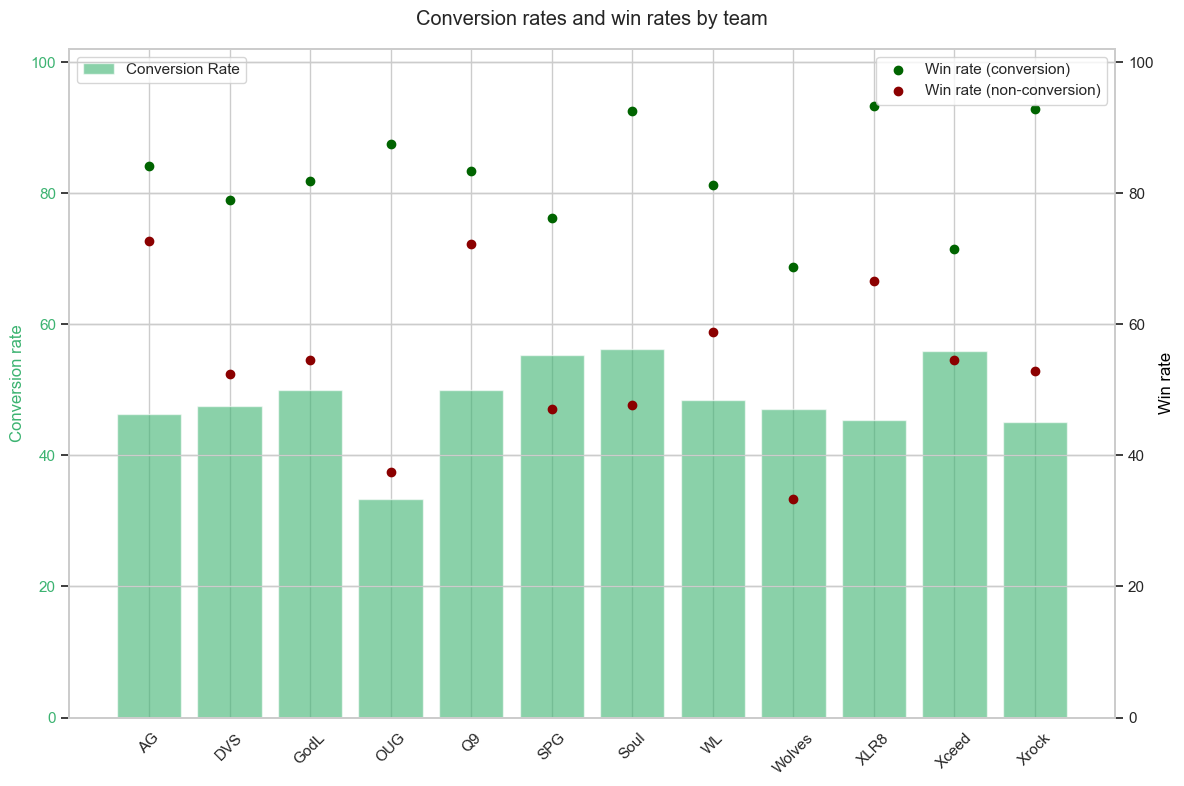

In [51]:
# Bar chart: conversion rate and win rates
fig, ax1 = plt.subplots(figsize=(12,8))
ax1.bar(conv_df.index, conv_df['ConversionRate'], color='mediumseagreen', alpha=0.6, label='Conversion Rate')
ax1.set_ylabel('Conversion rate', color='mediumseagreen')
ax1.set_ylim(0,102)
ax1.tick_params(axis='y', labelcolor='mediumseagreen')

ax2 = ax1.twinx()
ax2.scatter(conv_df.index, conv_df['ConversionWinRate'], color='darkgreen', marker='o', label='Win rate (conversion)')
ax2.scatter(conv_df.index, conv_df['NonConversionWinRate'], color='darkred', marker='o', label='Win rate (non-conversion)')
ax2.set_ylabel('Win rate', color='black')
ax2.set_ylim(0,102)

fig.suptitle('Conversion rates and win rates by team')
ax1.set_xticklabels(conv_df.index, rotation=45)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.show()

## 5. Median First Blood Times by Team

Finally, we calculate the median time of first blood for each team.  Lower numbers indicate that a team tends to secure their first kills early in the round.

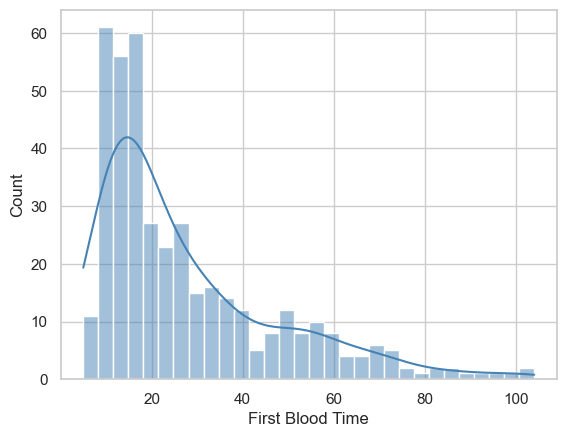

In [52]:
sns.histplot(df['First Blood Time'], bins=30, kde=True, color='steelblue');

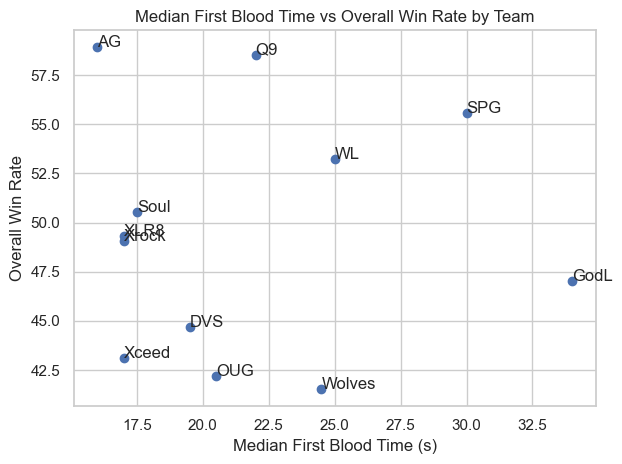

In [53]:
# Compute overall win rates per team
teams = sorted(set(df['Attack']) | set(df['Defense']))
stats = []
for team in teams:
    mask = (df['Attack'] == team) | (df['Defense'] == team)
    total = mask.sum()
    wins = (df.loc[mask, 'Winner'] == team).sum()
    win_rate = wins / total
    stats.append({'Team': team, 'win_rate': win_rate * 100})
df_win = pd.DataFrame(stats)

# Compute median first blood times per team
medians = df.groupby('First Blood Team')['First Blood Time'].median().reset_index()
medians.columns = ['Team', 'median_fb']

# Merge for plotting
df_plot = pd.merge(df_win, medians, on='Team')

# Add team logos
df_plot = df_plot.merge(logo_df, left_on='Team', right_on='Team', how='left')

df_plot.to_csv('median_fb_winrates.csv', index=False)

plt.figure()
plt.scatter(df_plot['median_fb'], df_plot['win_rate'])
for _, row in df_plot.iterrows():
    plt.text(row['median_fb'], row['win_rate'], row['Team'])
plt.xlabel('Median First Blood Time (s)')
plt.ylabel('Overall Win Rate')
plt.title('Median First Blood Time vs Overall Win Rate by Team')
plt.tight_layout()
plt.show()

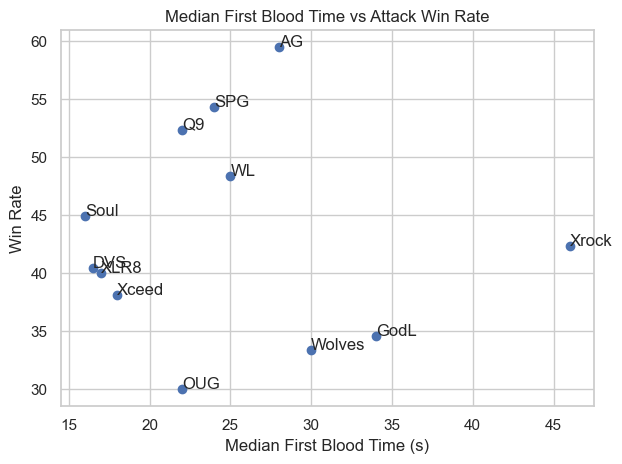

In [54]:
# Divide into attack and defense roles
stats = []
for team in teams:
    mask = (df['Attack'] == team)
    total = mask.sum()
    wins = (df.loc[mask, 'Winner'] == team).sum()
    win_rate = wins / total
    stats.append({'Team': team, 'win_rate': win_rate*100})
df_win_on_attack = pd.DataFrame(stats)

# Compute median first blood times per team
attack_gets_first_blood = df['First Blood Team'] == df['Attack']
df_attack_gets_fb = df[attack_gets_first_blood]
medians_attack = df_attack_gets_fb.groupby('First Blood Team')['First Blood Time'].median().reset_index()
medians_attack.columns = ['Team', 'median_fb']

# Merge for plotting
df_plot = pd.merge(df_win_on_attack, medians_attack, on='Team')
df_plot.to_csv('median_fb_winrates_attack.csv', index=False)

plt.figure()
plt.scatter(df_plot['median_fb'], df_plot['win_rate'])
for _, row in df_plot.iterrows():
    plt.text(row['median_fb'], row['win_rate'], row['Team'])
plt.xlabel('Median First Blood Time (s)')
plt.ylabel('Win Rate')
plt.title('Median First Blood Time vs Attack Win Rate')
plt.tight_layout()
plt.show()

In [64]:
df_plot

,Team,win_rate,median_fb
0,AG,59.459459,28.0
1,DVS,40.425532,16.5
2,GodL,34.615385,34.0
3,OUG,30.000000,22.0
4,Q9,52.380952,22.0
5,SPG,54.285714,24.0
6,Soul,44.897959,16.0
7,WL,48.387097,25.0
8,Wolves,33.333333,30.0
9,XLR8,40.000000,17.0


## Match Level Data

In [55]:
# Condense into match-level statistics
df['Team1'] = df[['Attack', 'Defense']].min(axis=1)
df['Team2'] = df[['Attack', 'Defense']].max(axis=1)

matches = []
for (t1, t2, m), group in df.groupby(['Team1', 'Team2', 'Map']):
    wins_t1 = (group['Winner'] == t1).sum()
    wins_t2 = (group['Winner'] == t2).sum()
    matches.append({
        'Team1': t1,
        'Team2': t2,
        'Map': m,
        'Team1Wins': wins_t1,
        'Team2Wins': wins_t2,
        'Score': f'{wins_t1}-{wins_t2}',
    })
match_df = pd.DataFrame(matches)

match_df.to_csv('match_summary.csv', index=False)

In [56]:
# Most commonly played maps
map_counts = match_df['Map'].value_counts().reset_index()
map_counts.columns = ['Map', 'MatchesPlayed']
map_counts.to_csv('map_counts.csv', index=False)
map_counts

,Map,MatchesPlayed
0,Coastal,8
1,Tunisia,6
2,Kurohana,6
3,Firing Range,4
4,Standoff,3


In [57]:
# Team win-loss records and round differentials
# Reshape to long form
team1_df = match_df.rename(columns={'Team1': 'Team', 'Team2': 'Opponent', 'Team1Wins': 'TeamScore', 'Team2Wins': 'OppScore'})[['Team', 'Opponent', 'Map', 'TeamScore', 'OppScore']]
team2_df = match_df.rename(columns={'Team2': 'Team', 'Team1': 'Opponent', 'Team2Wins': 'TeamScore', 'Team1Wins': 'OppScore'})[['Team', 'Opponent', 'Map', 'TeamScore', 'OppScore']]
long_df = pd.concat([team1_df, team2_df], ignore_index=True)

long_df['Win'] = (long_df['TeamScore'] > long_df['OppScore']).astype(int)
long_df['RoundDiff'] = long_df['TeamScore'] - long_df['OppScore']

team_stats = long_df.groupby('Team').agg(
    MatchesPlayed=('Opponent', 'count'),
    MatchesWon=('Win', 'sum'),
    MatchesLost=('Win', lambda x: x.count() - x.sum()),
    CumulativeRoundDiff=('RoundDiff', 'sum')
).reset_index().sort_values('CumulativeRoundDiff', ascending=False)
team_stats.reset_index(drop=True, inplace=True)
team_stats.to_csv('team_win_loss_records.csv', index=False)
team_stats

,Team,MatchesPlayed,MatchesWon,MatchesLost,CumulativeRoundDiff
0,Q9,5,4,1,14
1,AG,5,4,1,13
2,SPG,5,3,2,8
3,WL,4,3,1,4
4,Soul,6,2,4,1
5,XLR8,5,2,3,-1
6,Xrock,4,2,2,-1
7,GodL,3,1,2,-3
8,OUG,3,1,2,-7
9,Xceed,4,2,2,-7


In [60]:
# Top 3Highest and Lowest Margins
match_df['Margin'] = abs(match_df['Team1Wins'] - match_df['Team2Wins'])
top3_highest = match_df.nlargest(5, 'Margin')[['Team1', 'Team2', 'Score', 'Map']]
top3_lowest = match_df.nsmallest(5, 'Margin')[['Team1', 'Team2', 'Score', 'Map']]

top3_highest.to_csv('top3_highest_margins.csv', index=False)
top3_lowest.to_csv('top3_lowest_margins.csv', index=False)

In [62]:
top3_highest, top3_lowest

(   Team1   Team2 Score           Map
 19   SPG   Xrock   9-1  Firing Range
 23  Soul   Xceed   9-1       Coastal
 12   OUG      Q9   2-9       Coastal
 17   SPG  Wolves   9-3      Kurohana
 20   SPG   Xrock   3-9      Kurohana,
   Team1 Team2 Score       Map
 2    AG    WL   7-9   Coastal
 5   DVS  Soul   9-7   Coastal
 6   DVS  Soul  10-8   Tunisia
 7   DVS    WL  8-10  Kurohana
 9  GodL   OUG  8-10   Coastal)

## Map-Level Data

In [63]:
df['AttackWin'] = (df['Winner'] == df['Attack']).astype(int)
df['DefenseWin'] = (df['Winner'] == df['Defense']).astype(int)

# Aggregate by map
map_side_stats = (
    df
    .groupby('Map')
    .agg(
        AttackerWins=('AttackWin', 'sum'),
        DefenderWins=('DefenseWin', 'sum'),
        TotalRounds=('AttackWin', 'count')
    )
    .reset_index()
)
map_side_stats.to_csv('map_side_stats.csv', index=False)

map_side_stats

,Map,AttackerWins,DefenderWins,TotalRounds
0,Coastal,54,63,117
1,Firing Range,28,33,61
2,Kurohana,39,49,88
3,Standoff,23,24,47
4,Tunisia,35,57,92


## Key Insights

- **First blood advantage:** The overall win rate when a team gets the first kill is about 70%.  For most teams this advantage is substantial.  Teams like **AG**, **GodL**, **Soul**, **XLR8** and **Xrock** convert over 75% of their first-blood rounds into wins, while **Wolves** struggle with just a 42% win rate after first blood.
- **Timing of first blood:** There is little linear correlation between the timing of the first blood and winning the round.  However, kills within the **16–30 second** window have the highest win rate (~82%), suggesting a sweet spot.  Extremely early (<15s) or mid‑to‑late (>30s) kills show lower conversion rates.
- **Trades (counter‑kills):** Nearly half of the rounds involve a trade (the opponent responds with the second kill).  When a trade occurs, the first blood team’s win rate drops to about **56%** versus **85%** when they secure both kills.  The time taken to trade is not strongly correlated with the outcome, but trades occurring more than ~20 seconds after the first blood tend to favor the first blood team.
- **Conversions:** Converting the first blood into a second kill dramatically improves a team’s chance of winning.  Most teams win nearly all rounds when they secure both the first and second kills.  Without the conversion the win rates drop significantly; for example **Soul** and **Xrock** win every conversion round but only ~40–70% of non‑conversion rounds.
- **Median first blood times:** Teams like **Soul**, **Xceed** and **Xrock** tend to secure the opening kill early (median ~14–17 s), while **SPG**, **GodL** and **Wolves** often wait until around the 30–33 s mark.  Early‑killing teams generally enjoy higher conversion rates.

These findings highlight the importance of capitalizing on the first kill by either quickly trading back if you’re on the losing side or converting into a second kill if you’re in the lead.  The timing of engagements appears secondary to how teams manage the manpower advantage and respond to early picks.
